In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score
import pandas as pd
from tqdm import tqdm
import AA_Import_LCP_Functions as chase_lcc

# Data Import

In [2]:
lccdata_folder = 'lccdata_files'

# Import LCC data files for wild type protein and mutant protein
wt_dict = chase_lcc.import_lcc_data(lccdata_folder, 'w')
D132H_dict = chase_lcc.import_lcc_data(lccdata_folder, 'm')

# Random Forest

In [3]:
def unison_shuffled_copies(a, b):
    assert len(a) == len(b)
    p = np.random.permutation(len(a))
    return a[p], b[p]

def prepare_data_x(wt_dict, D132H_dict, window_size):
    wildtype_data = wt_dict[window_size]
    wildtype_label = np.zeros(len(wildtype_data))
    mutant_data = D132H_dict[window_size]
    mutant_label = np.ones(len(mutant_data))

    lcc_data = np.vstack((wildtype_data, mutant_data))
    label_data = np.hstack((wildtype_label, mutant_label))
    lcc_data, label_data = unison_shuffled_copies(lcc_data, label_data)
    lcc_data /= 100
    upper_training_limit = int(len(lcc_data) * 0.8)
    
    # Splitting the data into training and testing sets
    X_train, X_test = lcc_data[:upper_training_limit], lcc_data[upper_training_limit:]
    y_train, y_test = label_data[:upper_training_limit], label_data[upper_training_limit:]

    return X_train, X_test, y_train, y_test

In [4]:
# Directory paths for saving feature importances
rf_dir = 'RF_Default_Feature_Importance'
xgb_dir = 'XGB_Default_Feature_Importance'

# Create directories if they don't exist
os.makedirs(rf_dir, exist_ok=True)
os.makedirs(xgb_dir, exist_ok=True)

# Initialize lists to store accuracies
rf_accuracies = []
xgb_accuracies = []
window_sizes = range(2, 52)  # Assuming window sizes from 2 to 51

for window_size in tqdm(window_sizes):
    X_train, X_test, y_train, y_test = prepare_data_x(wt_dict, D132H_dict, window_size)
    
    # Random Forest Classifier
    rf_filename = f"{rf_dir}/Feature_Importance_WS_{window_size}.csv"
    if not os.path.exists(rf_filename):
        rf_clf = RandomForestClassifier()
        rf_clf.fit(X_train, y_train)
        rf_predictions = rf_clf.predict(X_test)
        rf_acc = accuracy_score(y_test, rf_predictions)
        rf_accuracies.append(rf_acc)
        # Save feature importances
        pd.DataFrame(rf_clf.feature_importances_).to_csv(rf_filename, index=False)
    else:
        print("Feature Importances already saved for RF, Window Size:", window_size)
    
    # XGBoost Classifier
    xgb_filename = f"{xgb_dir}/Feature_Importance_WS_{window_size}.csv"
    if not os.path.exists(xgb_filename):
        xgb_clf = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
        xgb_clf.fit(X_train, y_train)
        xgb_predictions = xgb_clf.predict(X_test)
        xgb_acc = accuracy_score(y_test, xgb_predictions)
        xgb_accuracies.append(xgb_acc)
        # Save feature importances
        pd.DataFrame(xgb_clf.feature_importances_).to_csv(xgb_filename, index=False)
    else:
        print("Feature Importances already saved for XGB, Window Size:", window_size)

100%|███████████████████████████████████████████| 50/50 [42:19<00:00, 50.79s/it]


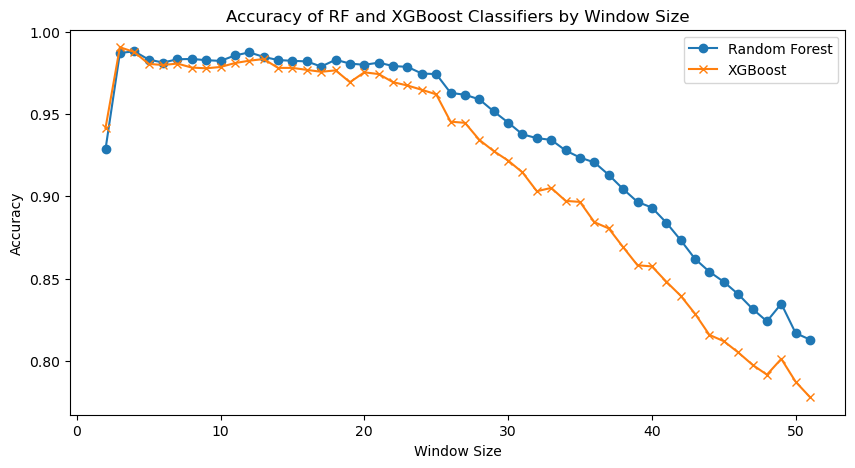

In [5]:
# Plotting the accuracies
plt.figure(figsize=(10, 5))
plt.plot(window_sizes, rf_accuracies, label='Random Forest', marker='o')
plt.plot(window_sizes, xgb_accuracies, label='XGBoost', marker='x')
plt.xlabel('Window Size')
plt.ylabel('Accuracy')
plt.title('Accuracy of RF and XGBoost Classifiers by Window Size')
plt.legend()
plt.show()

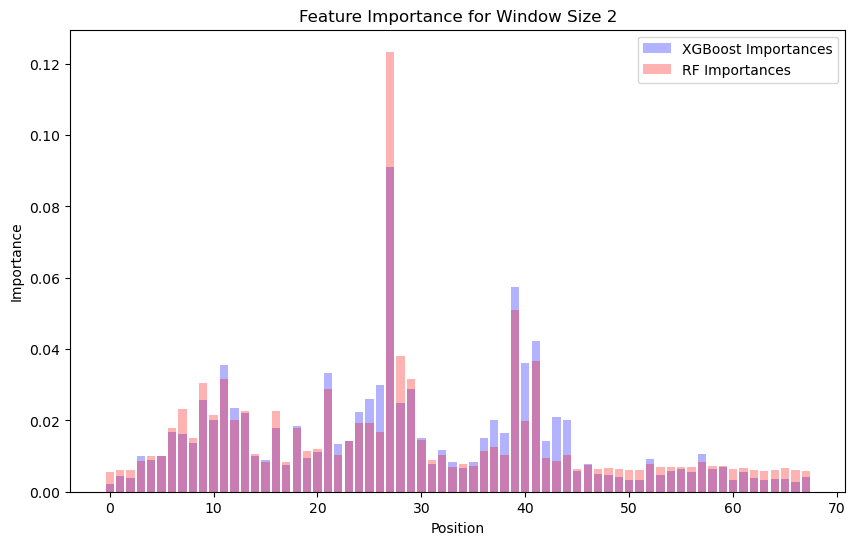

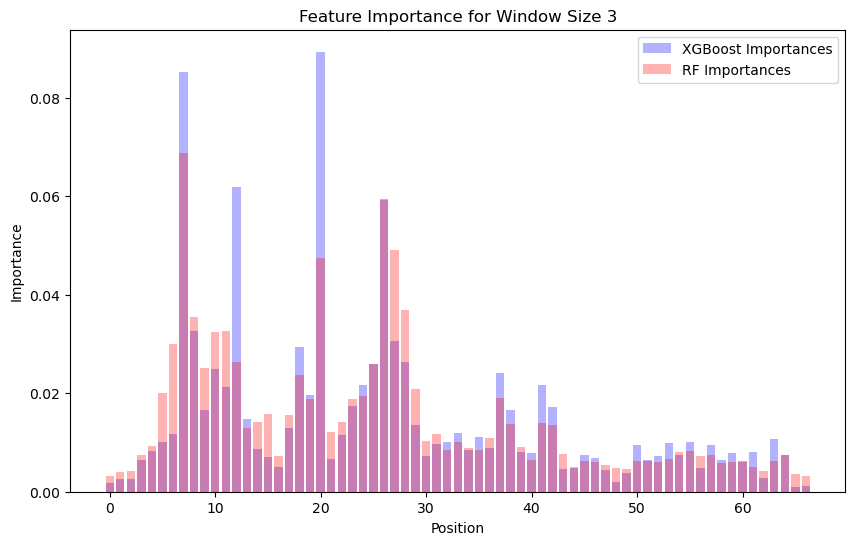

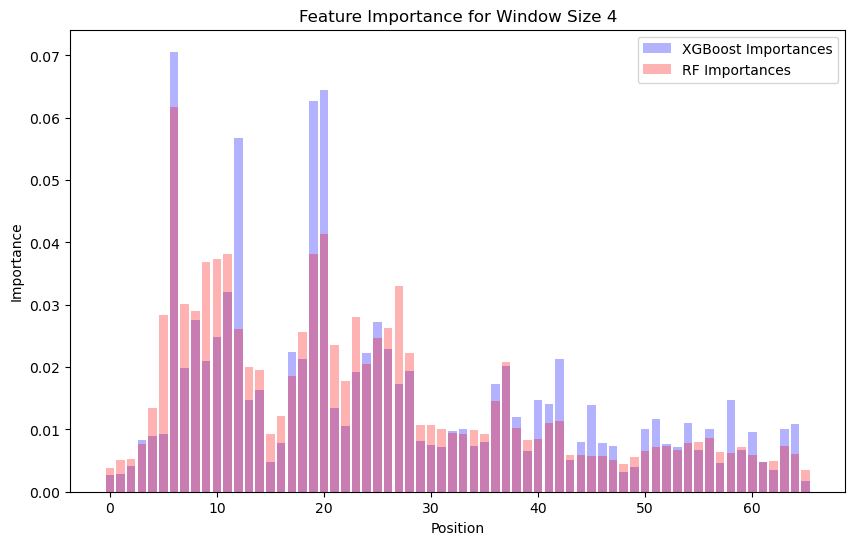

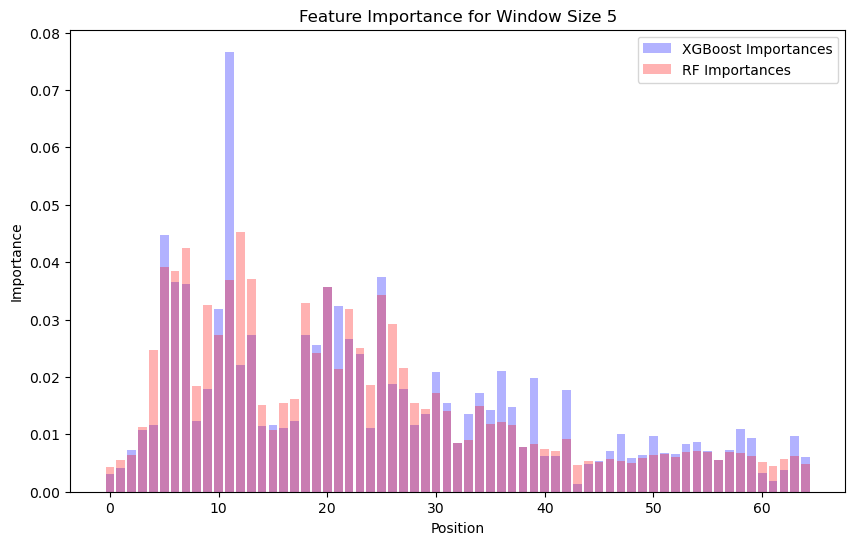

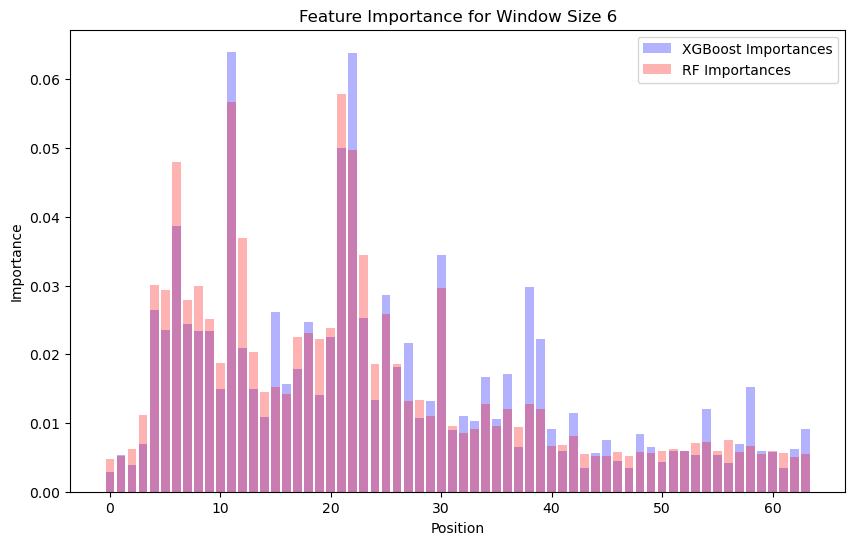

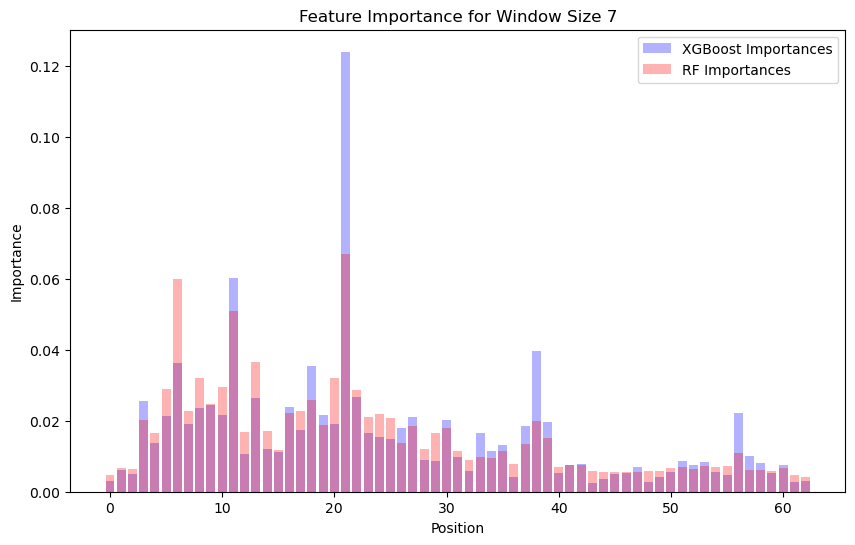

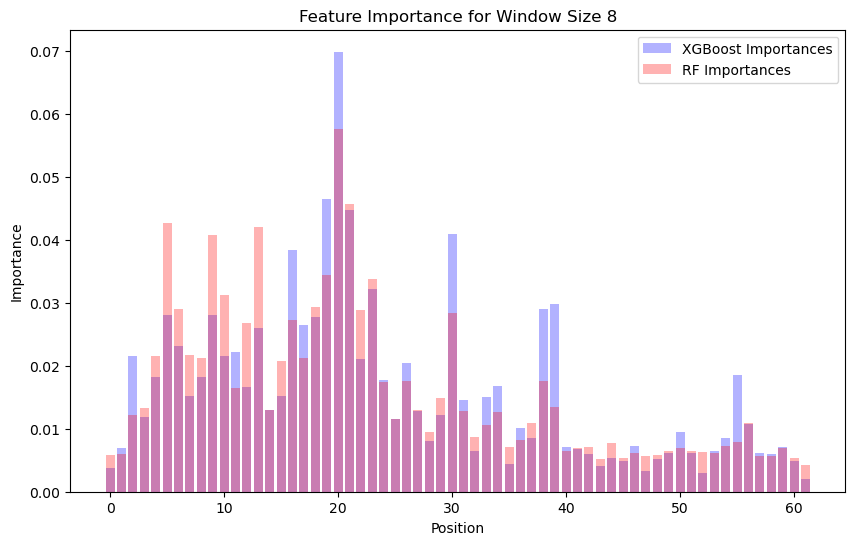

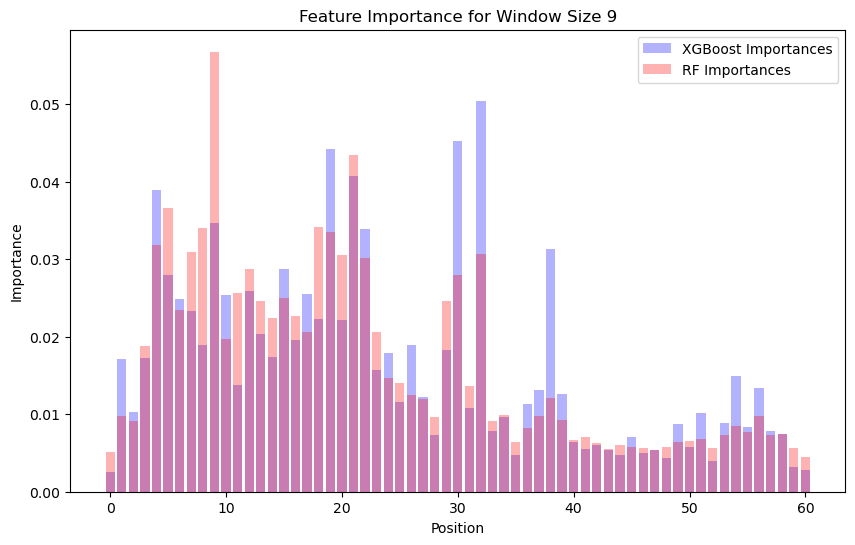

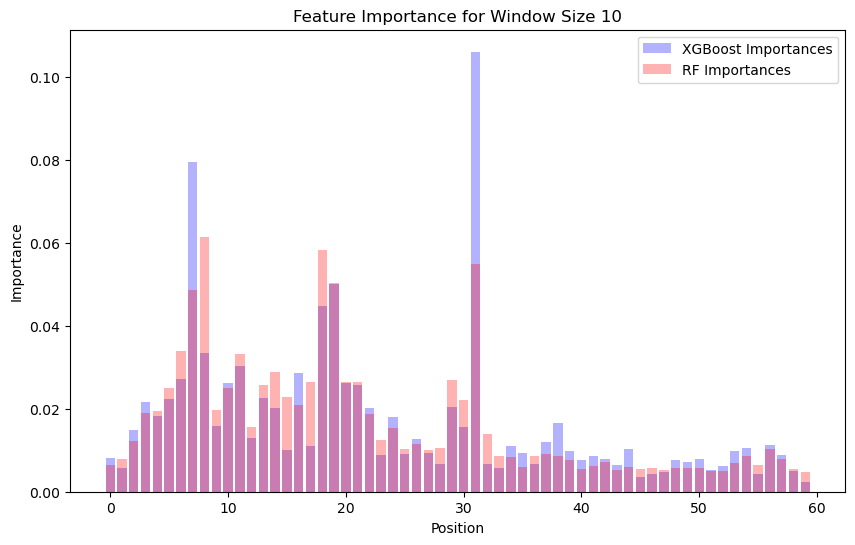

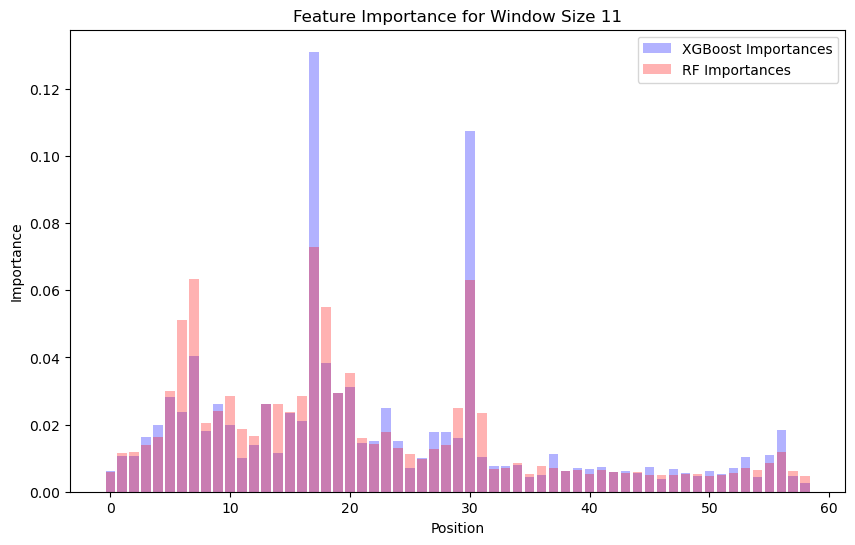

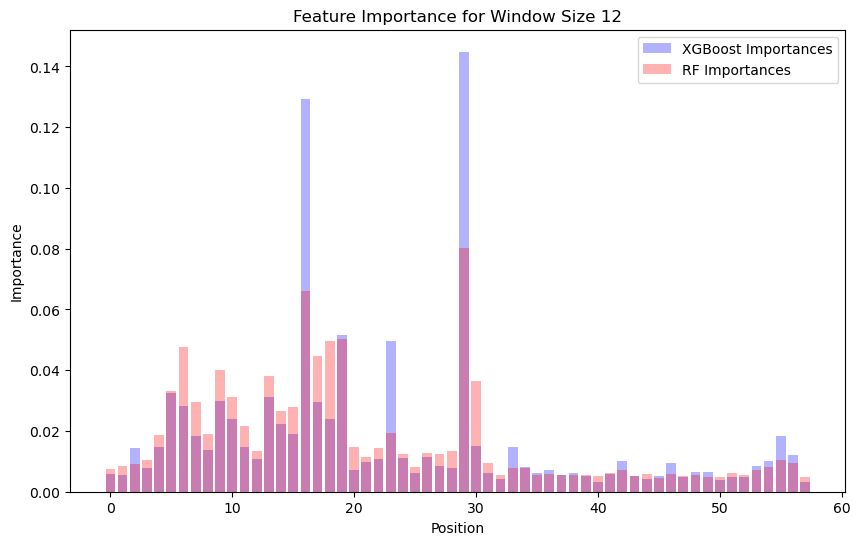

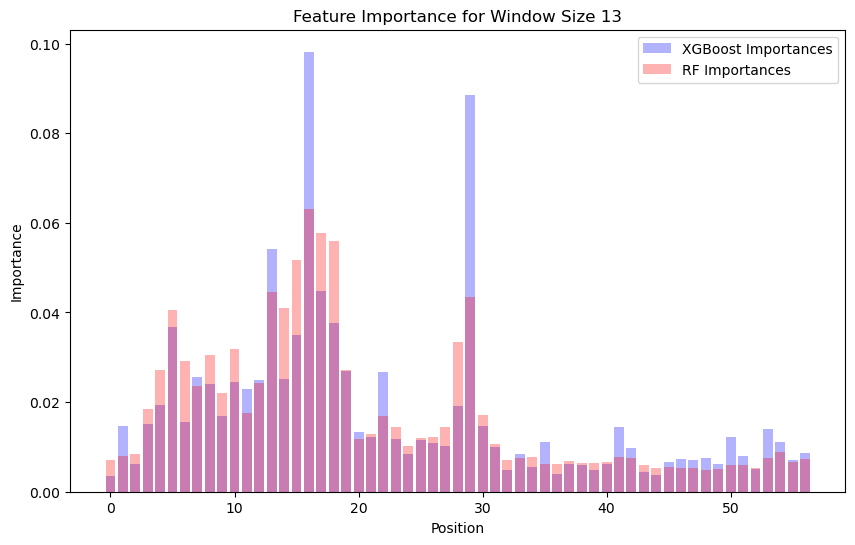

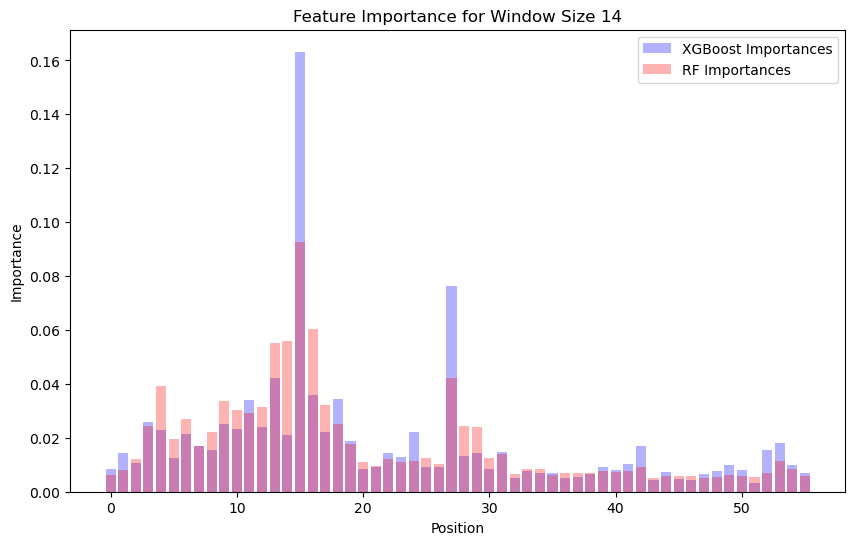

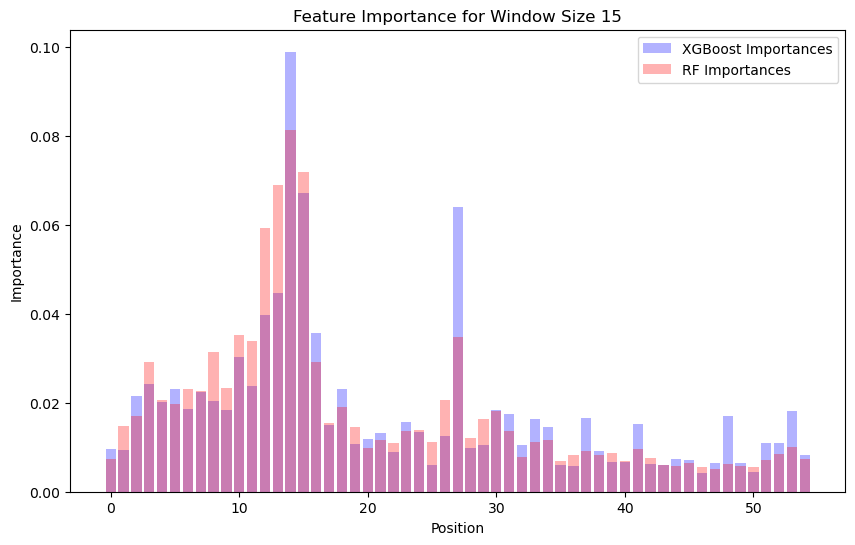

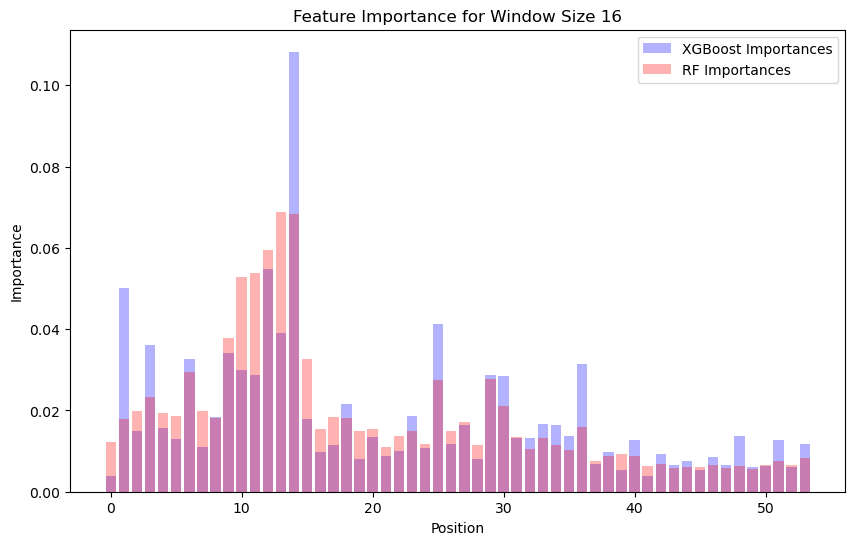

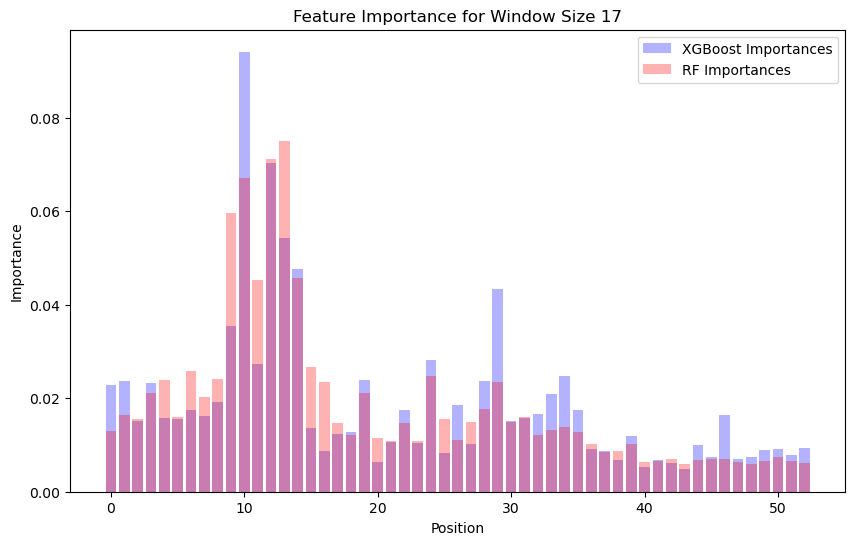

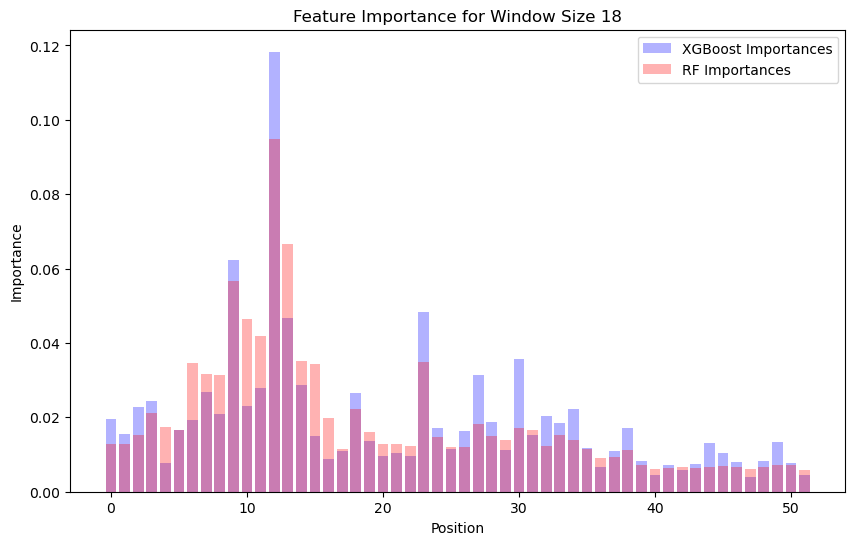

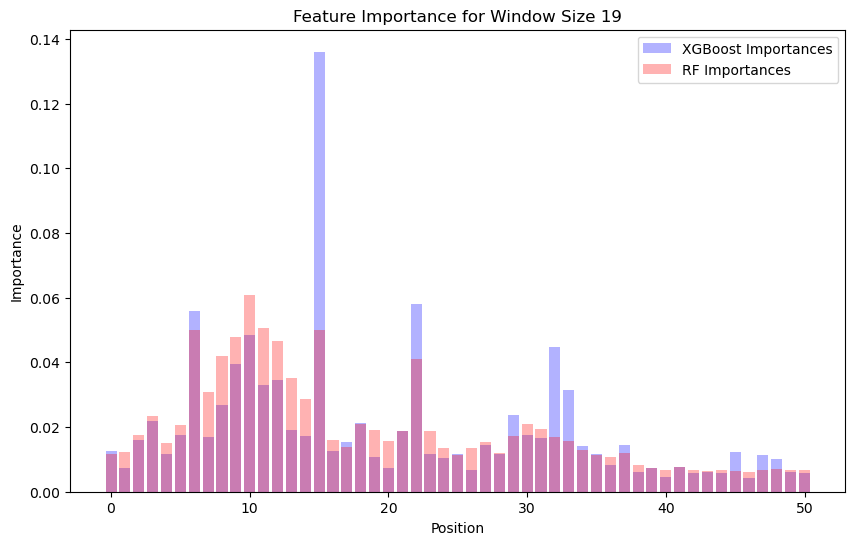

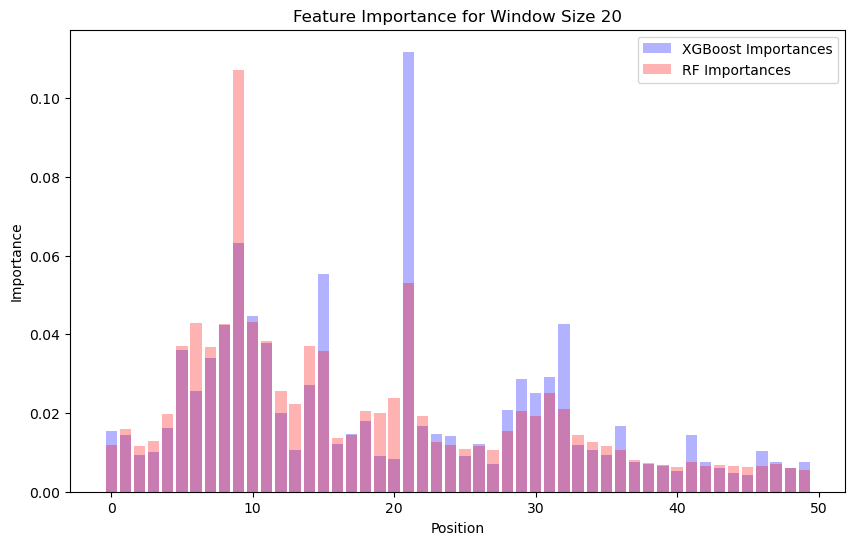

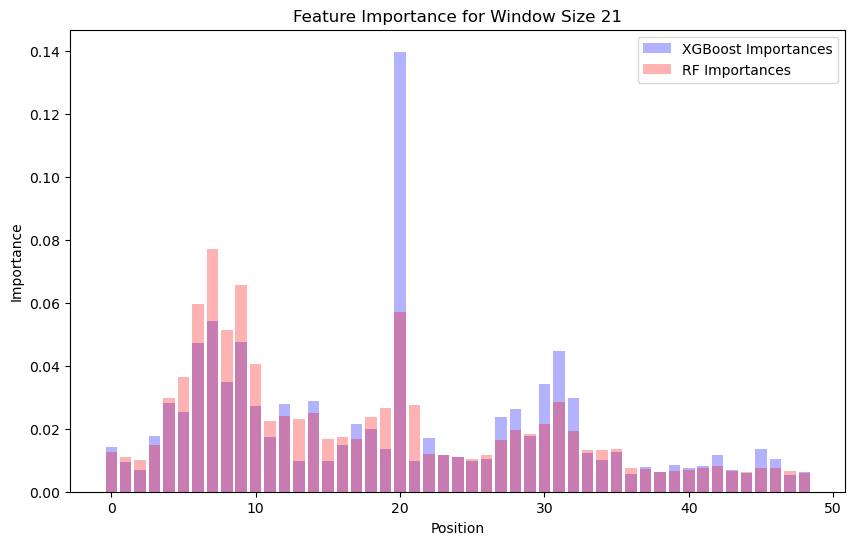

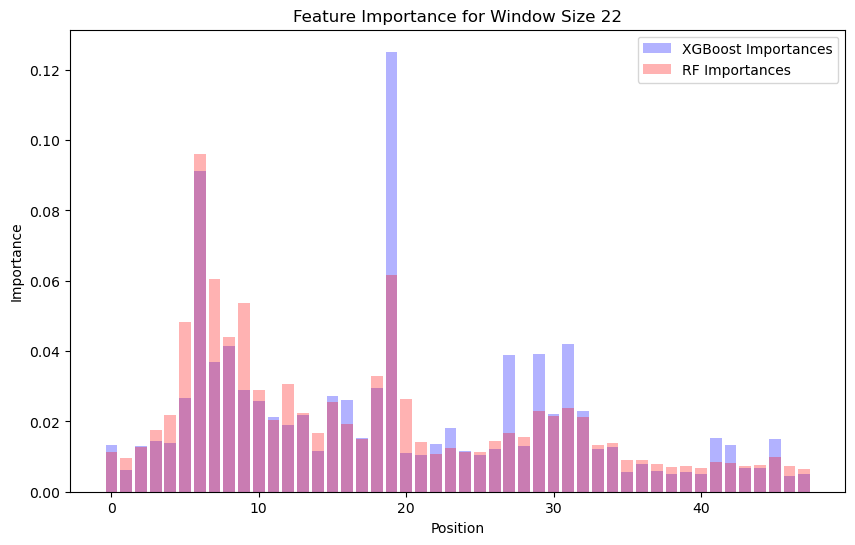

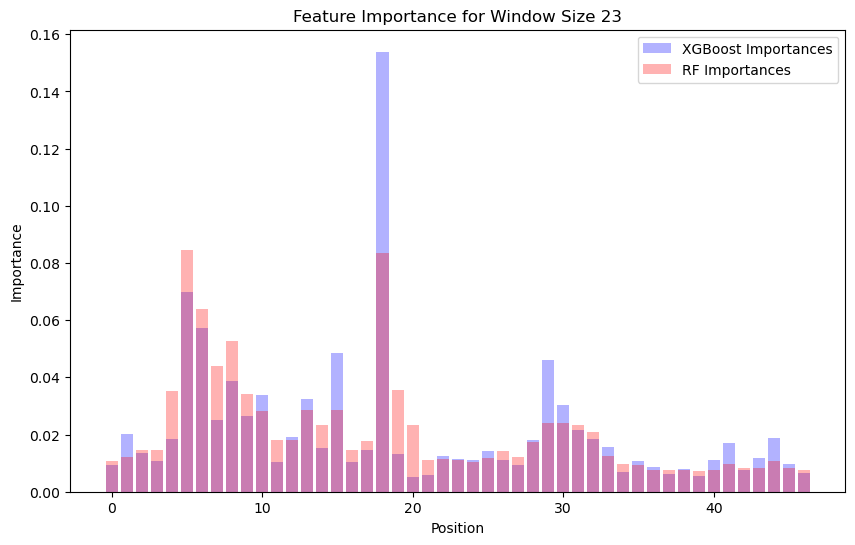

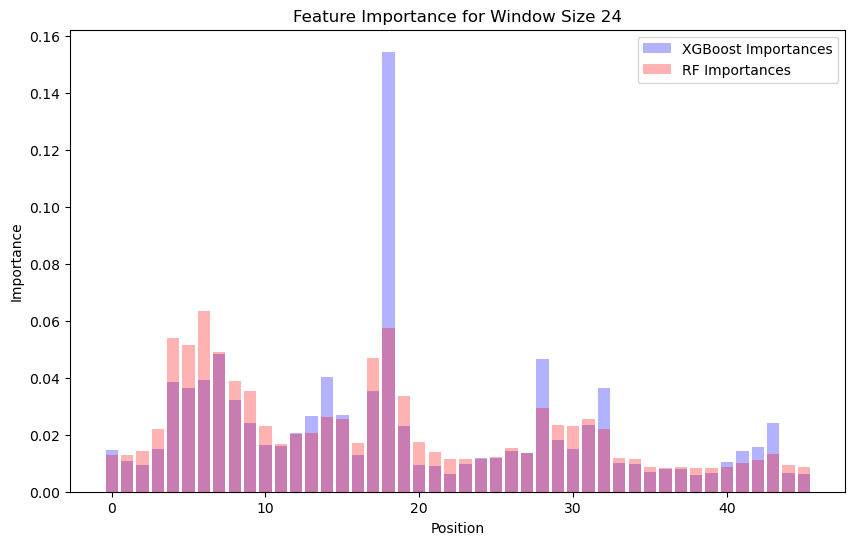

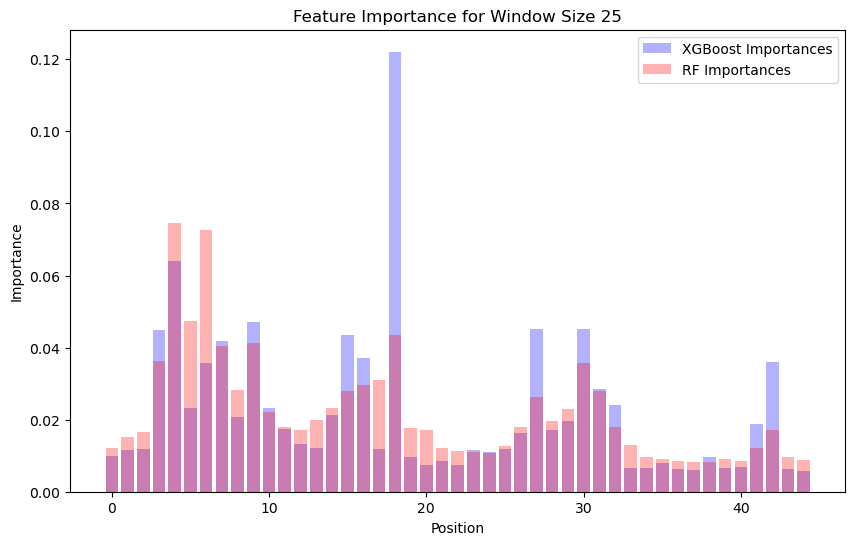

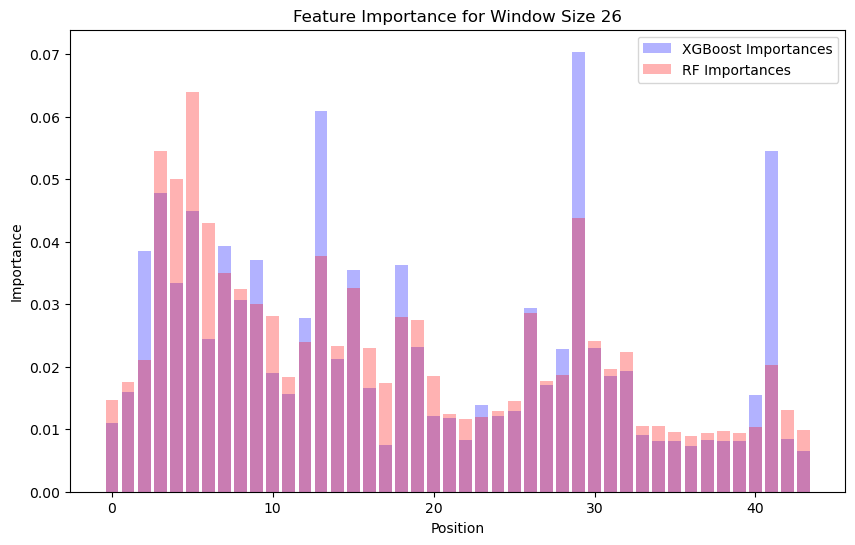

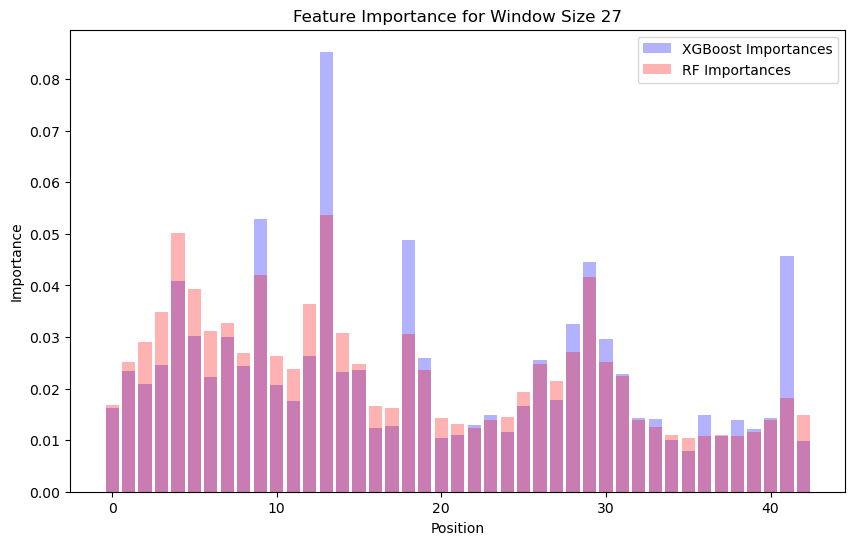

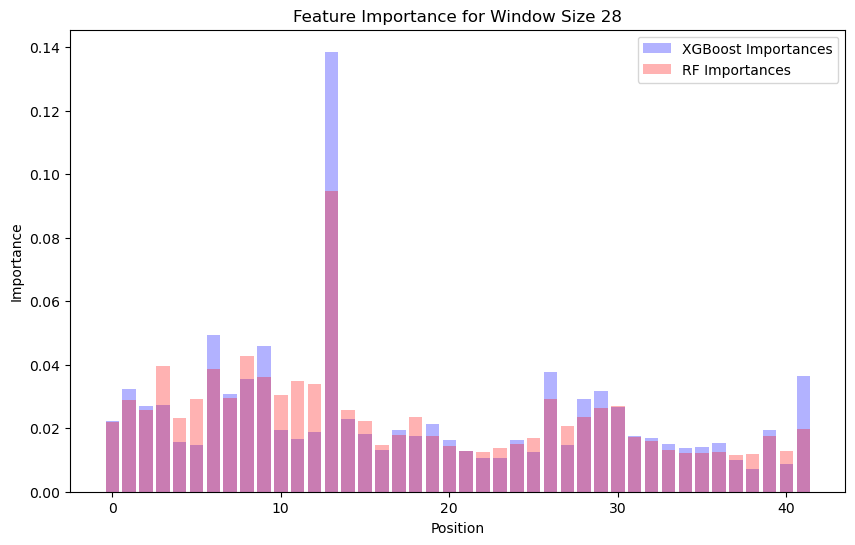

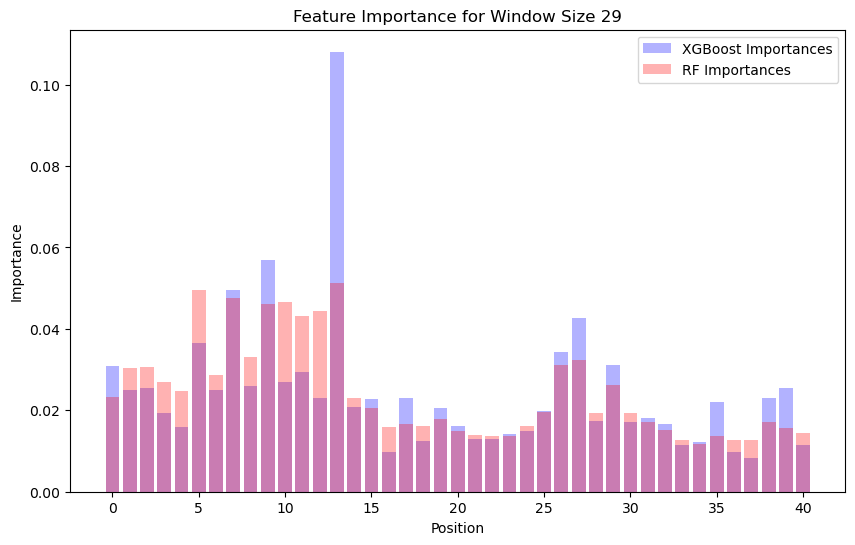

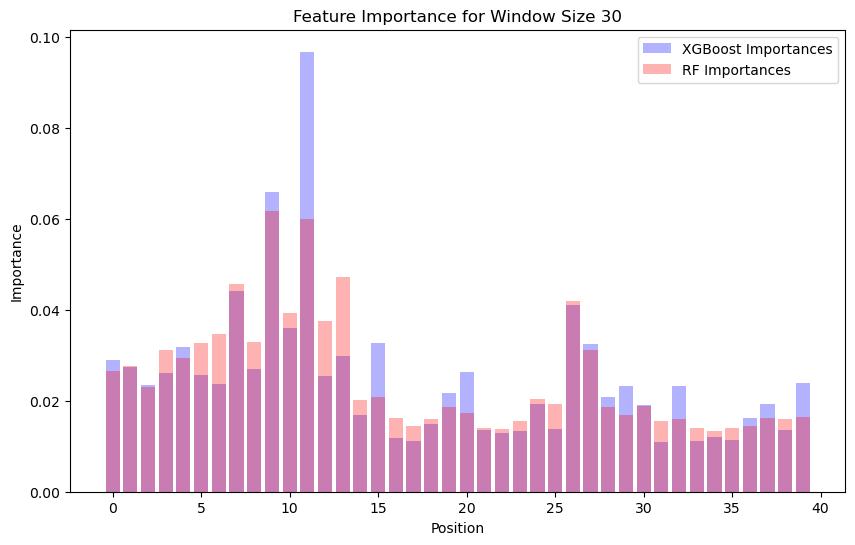

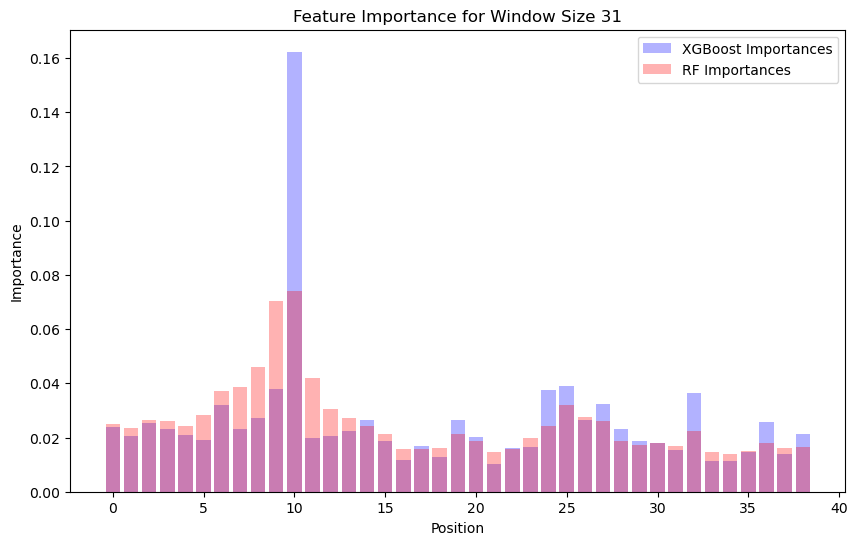

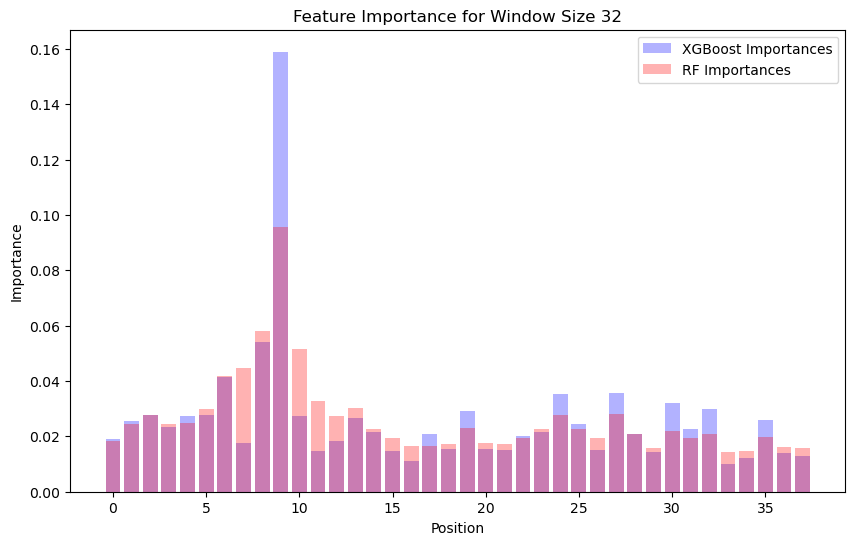

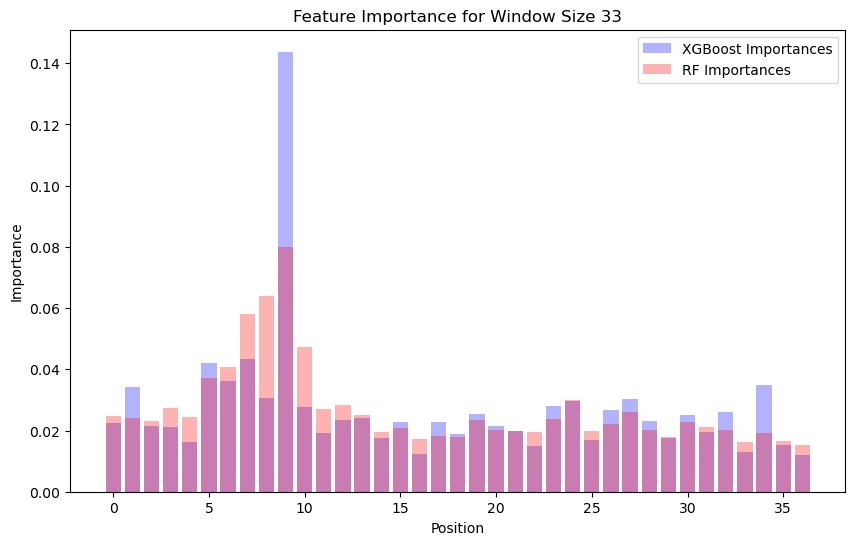

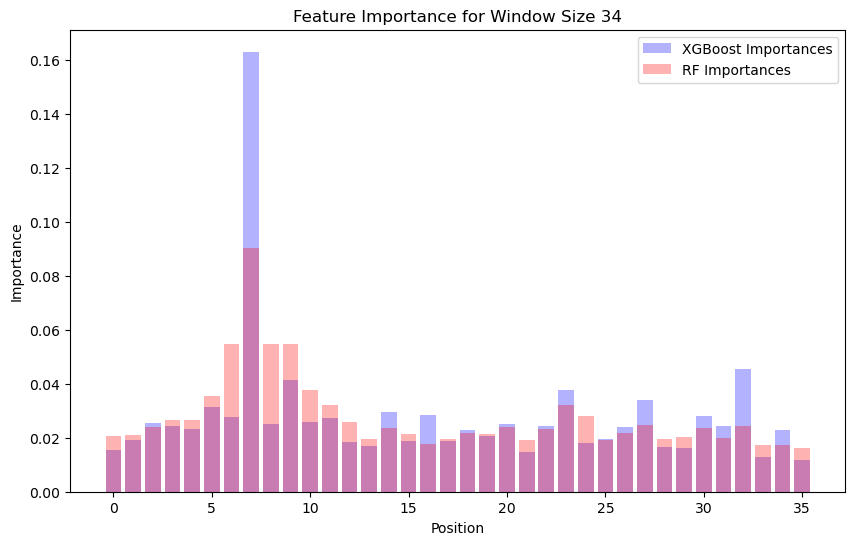

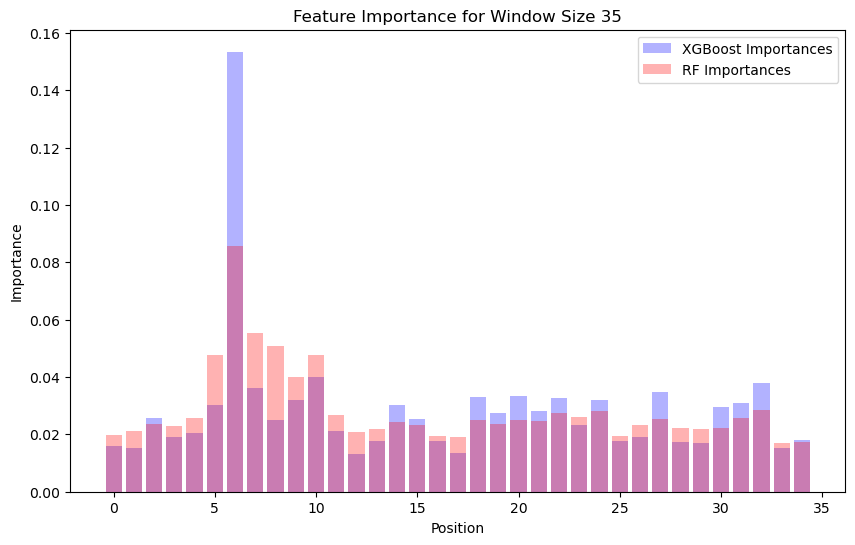

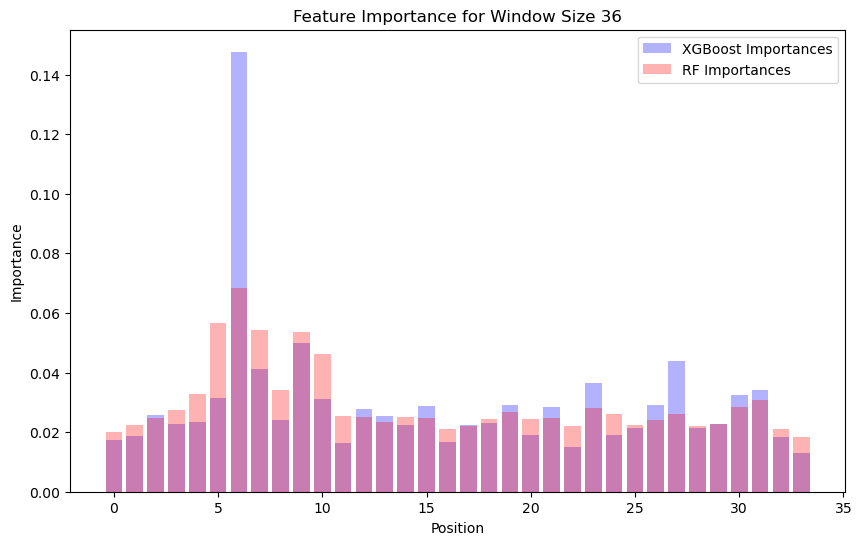

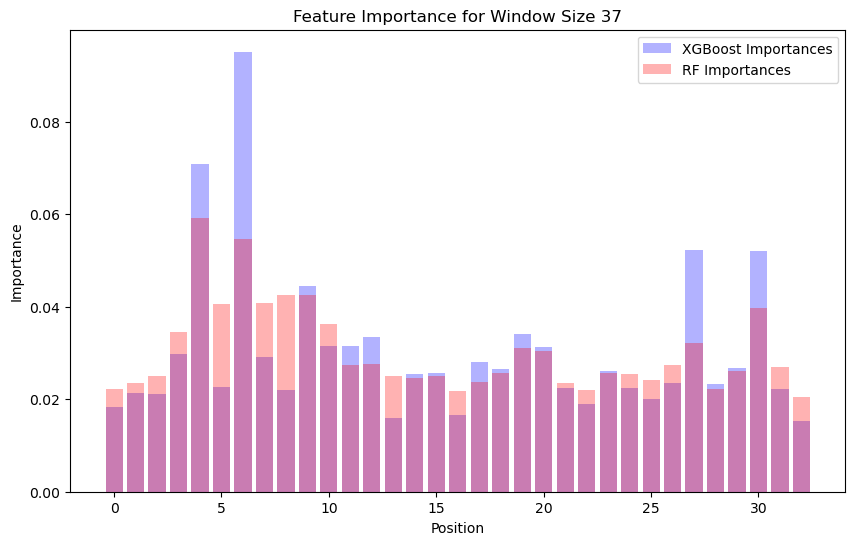

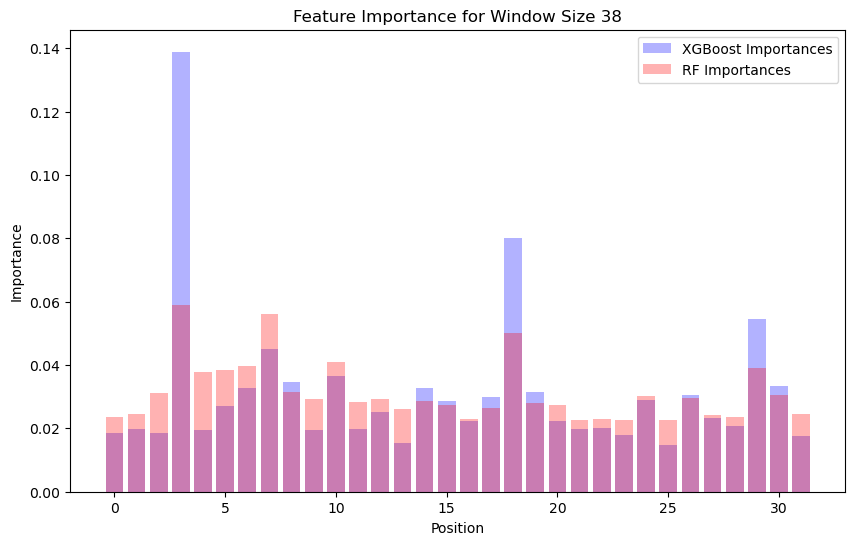

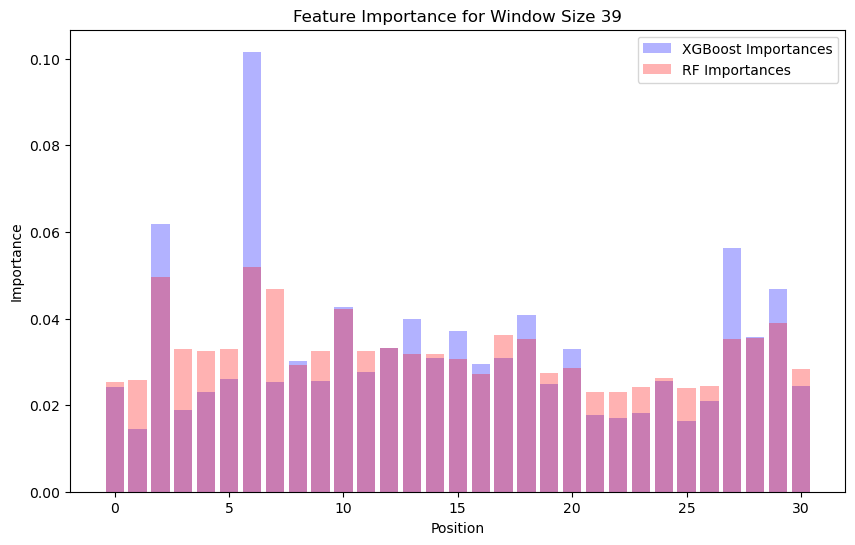

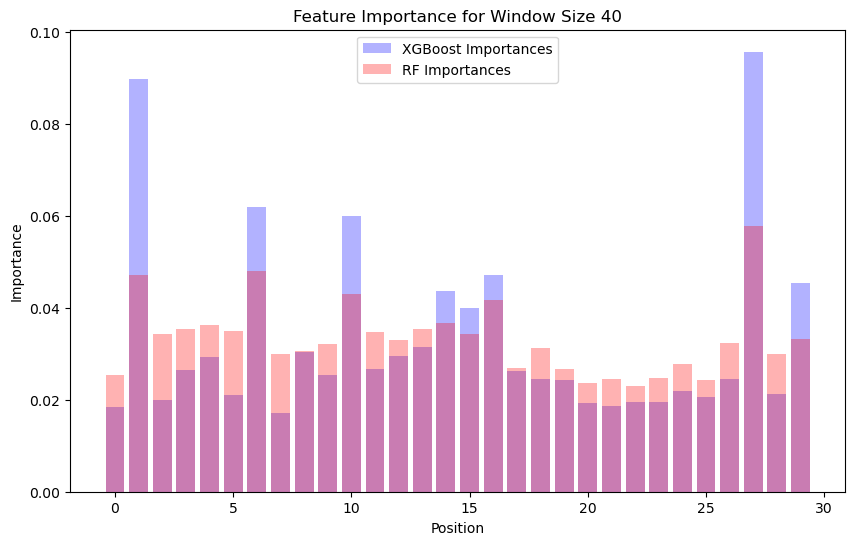

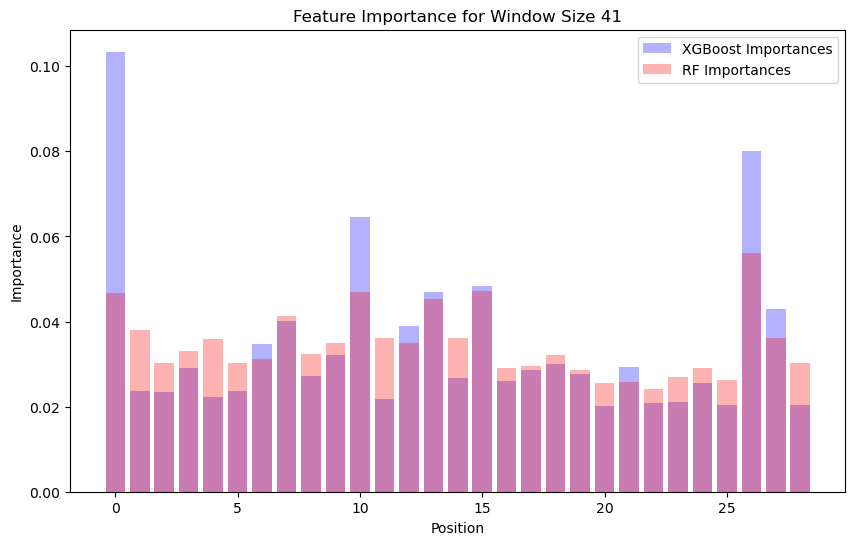

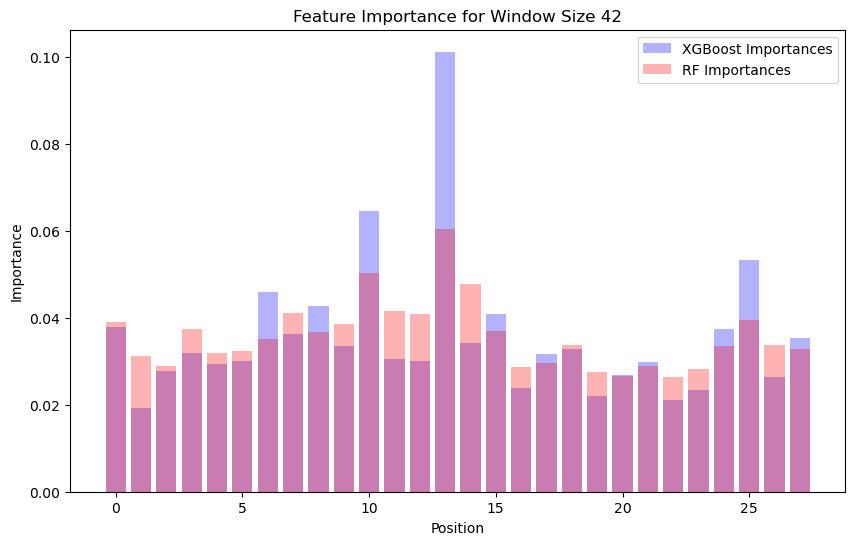

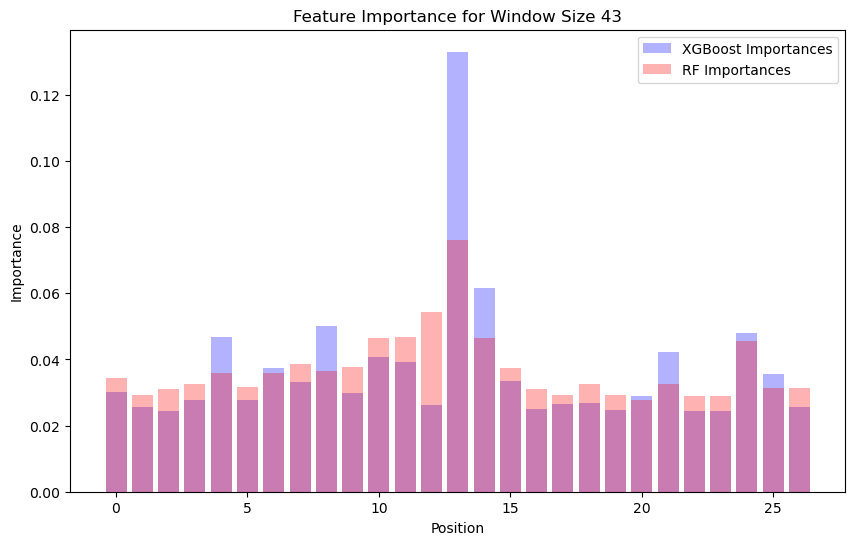

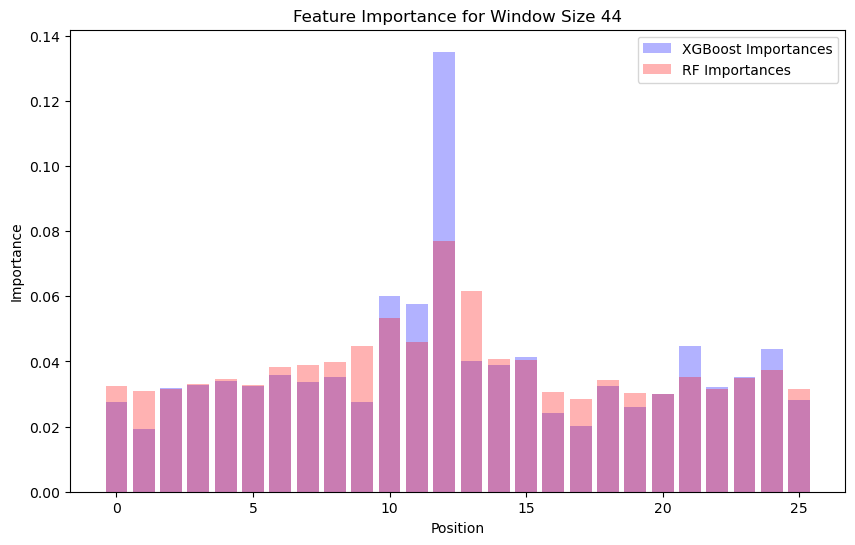

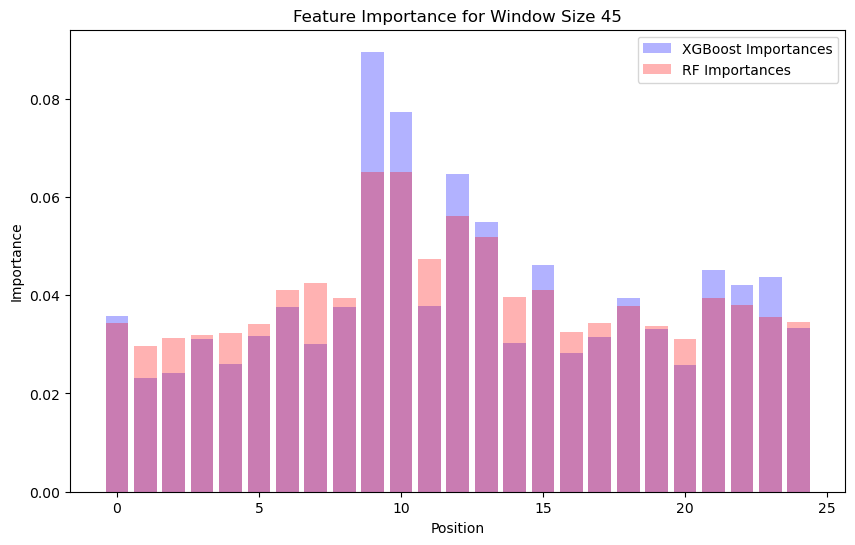

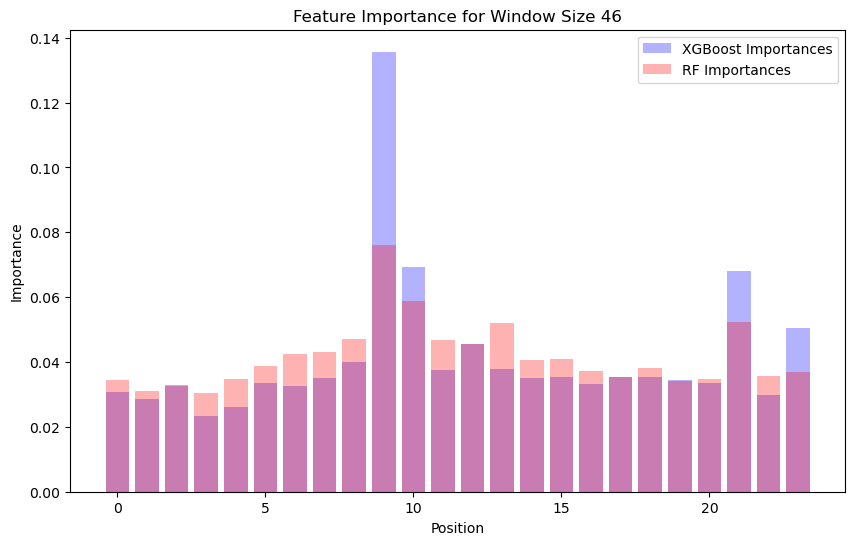

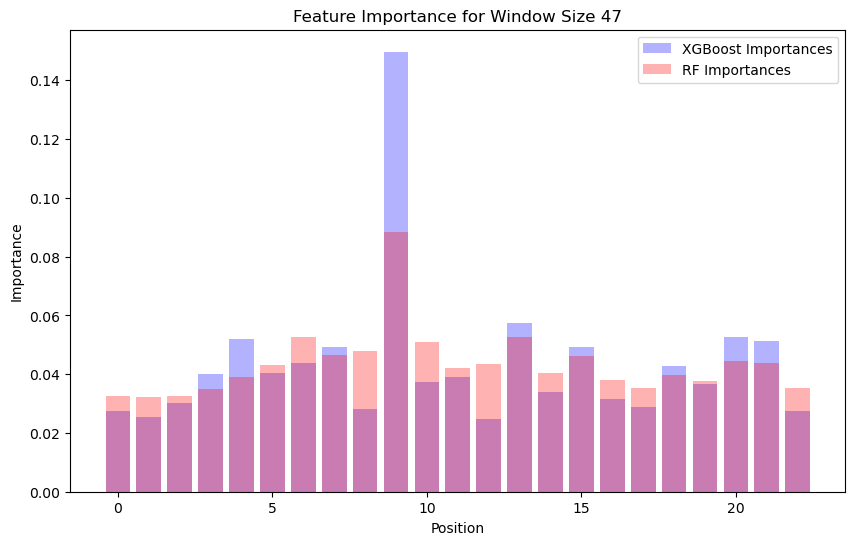

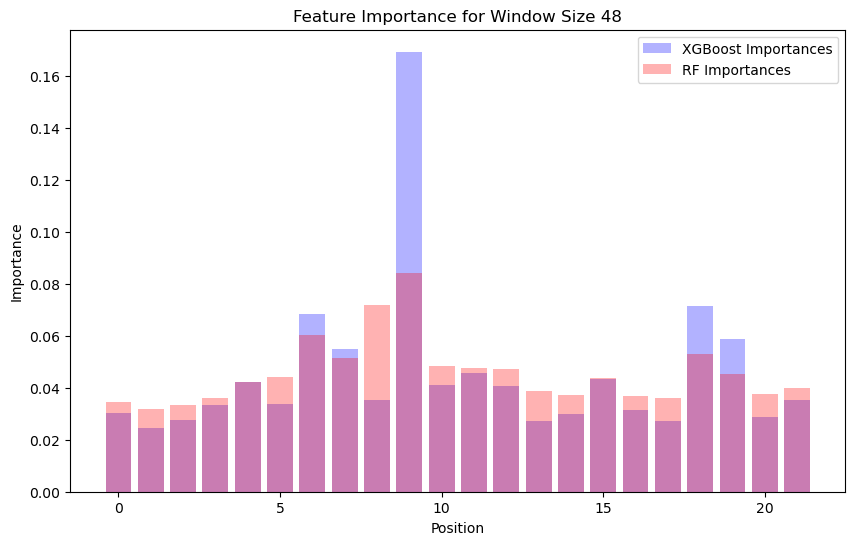

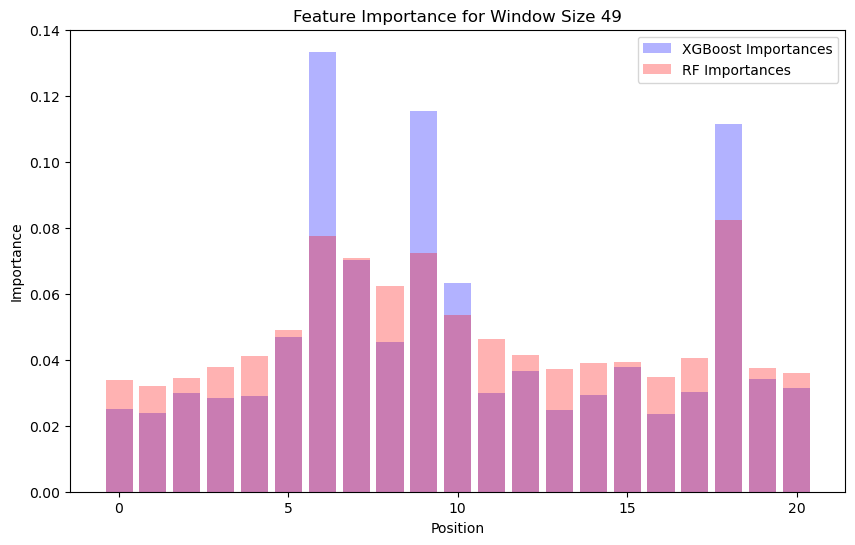

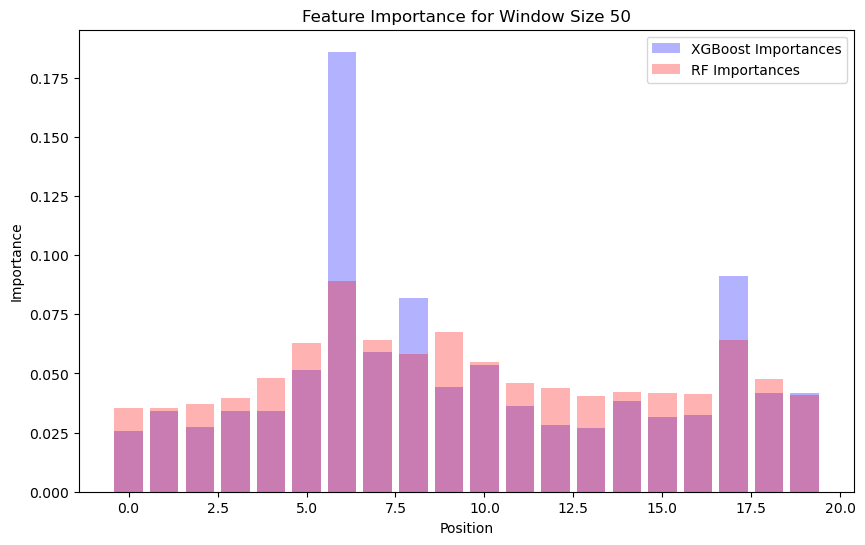

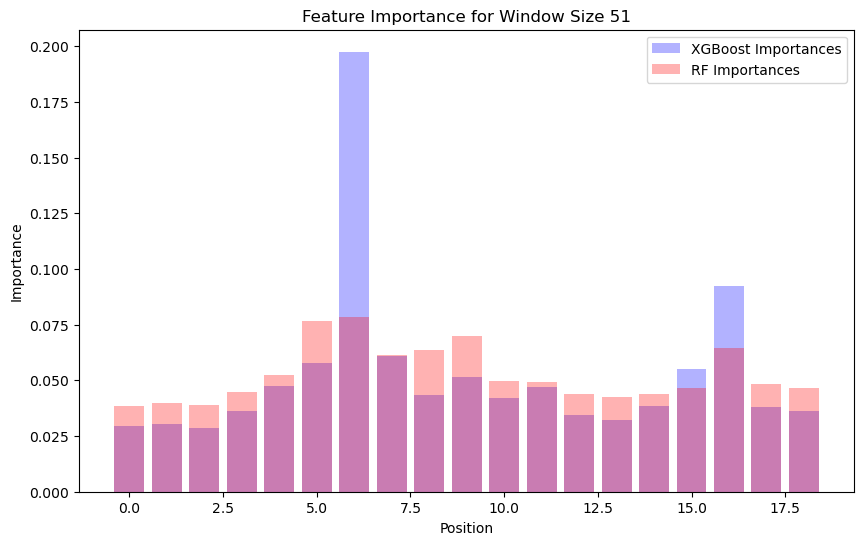

In [6]:
XGB_dir = "XGB_Default_Feature_Importance"
RF_dir = "RF_Default_Feature_Importance"

window_sizes = range(2, 52)

for window_size in window_sizes:
    # Filename for the current window size
    filename = f"Feature_Importance_WS_{window_size}.csv"

    # Paths to the default and select feature importances
    XGB_path = os.path.join(XGB_dir, filename)
    RF_path = os.path.join(RF_dir, filename)

    # Read the feature importances
    XGB_importances = pd.read_csv(XGB_path)
    RF_importances = pd.read_csv(RF_path)

    # Plotting
    plt.figure(figsize=(10, 6))
    plt.bar(range(len(XGB_importances)), XGB_importances.iloc[:, 0], alpha=0.3, color='blue', label='XGBoost Importances')
    plt.bar(range(len(RF_importances)), RF_importances.iloc[:, 0], alpha=0.3, color='red', label='RF Importances')
    plt.title(f'Feature Importance for Window Size {window_size}')
    plt.xlabel('Position')
    plt.ylabel('Importance')
    plt.legend()
    plt.show()